# ¿Que más se podría hacer?

In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- Test con data augmentation y la LSTM
- Usar los tokenizadores usados en los transformers para ver como funcionan
- TSNE de embeddings y analizar si hay interpretación
- Probar con otras encimas o proteinas
- Usar los embeddings entrenados para analizar resultados de proteinas o encimas con menos data
- Entrenar una red neuronal con los features (fingerprints por ejemplo) y comparar los resultados con los embeddings


# Tome cualquiera de estas propuestas o alguna suya y desarrolle

# Entrenamiento de una red neuronal utilizando los descriptores de Lipinski

In [85]:
import pandas as pd
import numpy as np
from pandas_summary import DataFrameSummary

## Obtención de datos para entrenamiento

In [86]:
RAW_DATA_PATH = 'data/acetylcholinesterase_02_bioactivity_data_preprocessed_full.pkl'

In [129]:
try:

    df = pd.read_pickle(RAW_DATA_PATH)

except FileNotFoundError:

    print("Preparando dataset...\n")
    
    # Descargo Data
    from chembl_webresource_client.new_client import new_client

    target = new_client.target
    target_query = target.search('acetylcholinesterase')
    targets = pd.DataFrame.from_dict(target_query)


    selected_target = targets.target_chembl_id[0]
    print(f"selected_target: {selected_target}\n")


    activity = new_client.activity
    res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

    res_cols = []
    for i, r in enumerate(res):
        print(f'downloaded: {i}\r', end='')
        res_cols.append(r)

    df = pd.DataFrame(res_cols)

    # Limpieza Data
    df = df.dropna(subset=['standard_value', 'canonical_smiles'])
    df = df.drop_duplicates(['canonical_smiles'])

    selection = ['molecule_chembl_id','canonical_smiles','standard_value']
    df = df[selection]    
    
    # Preprocesamiento y normalización
    df['standard_value'] = df['standard_value'].apply(pd.to_numeric)
    df['standard_value_norm'] = df['standard_value'].apply(lambda x: (x>1e8)*1e8 + (x<=1e8)*x)
    df['pIC50'] = df['standard_value'].apply(lambda x: -np.log10(x*(10**-9)))

    # Elimino datos no numericos de la columna target. De otro modo luego ocasionan inconvenientes durante 
    # el proceso de entrenamiento
    df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

    df.to_pickle(RAW_DATA_PATH)
    print("\nDataset descargado y listo para trabajar")

In [132]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


## Lipinski descriptors

In [104]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [105]:
# df = df[df.standard_value.notna()]
# df = df[df.canonical_smiles.notna()]
# df = df.drop_duplicates(['canonical_smiles'])
# df = df[['molecule_chembl_id','canonical_smiles','standard_value', 'standard_value_norm', 'pIC50']]

In [121]:
# df["canonical_smiles_bkp"] = df["canonical_smiles"].copy()
# df_no_smiles = df.drop(columns='canonical_smiles')

In [131]:
df["canonical_smiles"].apply(
    lambda x: max(
        x.split('.'), key=len
    )
)

0                   CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1              O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2       CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3           O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4               CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
                              ...                        
8384    CC1=CC2Cc3nc4cc(Cl)ccc4c(NCCCCCCCCCNC(=O)c4cc(...
8385    CC1=CC2Cc3nc4cc(Cl)ccc4c(NCCCCCCCCC(=O)Nc4cn[n...
8386    CC1=CC2Cc3nc4cc(Cl)ccc4c(NCCCCCCCCC(=O)N4CCNC(...
8387    CC1=CC2Cc3nc4cc(Cl)ccc4c(NCCCCCCCCC(=O)NCc4cc[...
8388    COc1cc(CNC(=O)CCCCCCCCNc2c3c(nc4cc(Cl)ccc24)CC...
Name: canonical_smiles, Length: 5823, dtype: object

In [92]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        try:
            mol=Chem.MolFromSmiles(elem) 
        except:
            print(elem)
            raise
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(
        data=baseData,
        columns=columnNames
    )
    
    return descriptors
     


In [135]:
df_lipinski = lipinski(df.canonical_smiles)

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.8032,0.0,6.0
1,376.913,4.5546,0.0,5.0
2,426.851,5.3574,0.0,5.0
3,404.845,4.7069,0.0,5.0
4,346.334,3.0953,0.0,6.0
...,...,...,...,...
5818,562.154,7.8680,4.0,5.0
5819,506.094,7.3886,3.0,4.0
5820,523.121,5.9852,2.0,4.0
5821,547.143,7.0315,3.0,4.0


In [144]:
df.reset_index(drop=True, inplace=True)
df_lipinski.reset_index(drop=True, inplace=True)

In [147]:
df = pd.concat([df, df_lipinski], axis=1)

In [151]:
df.head(3)

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939,312.325,2.8032,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000,376.913,4.5546,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030,426.851,5.3574,0.0,5.0


In [152]:
LIPINSKY_DATA_PATH = 'data/acetylcholinesterase_02_bioactivity_data_preprocessed_with_lipinkski_desc.pkl'

df.to_pickle(LIPINSKY_DATA_PATH)

## EDA

In [180]:
import seaborn as sns

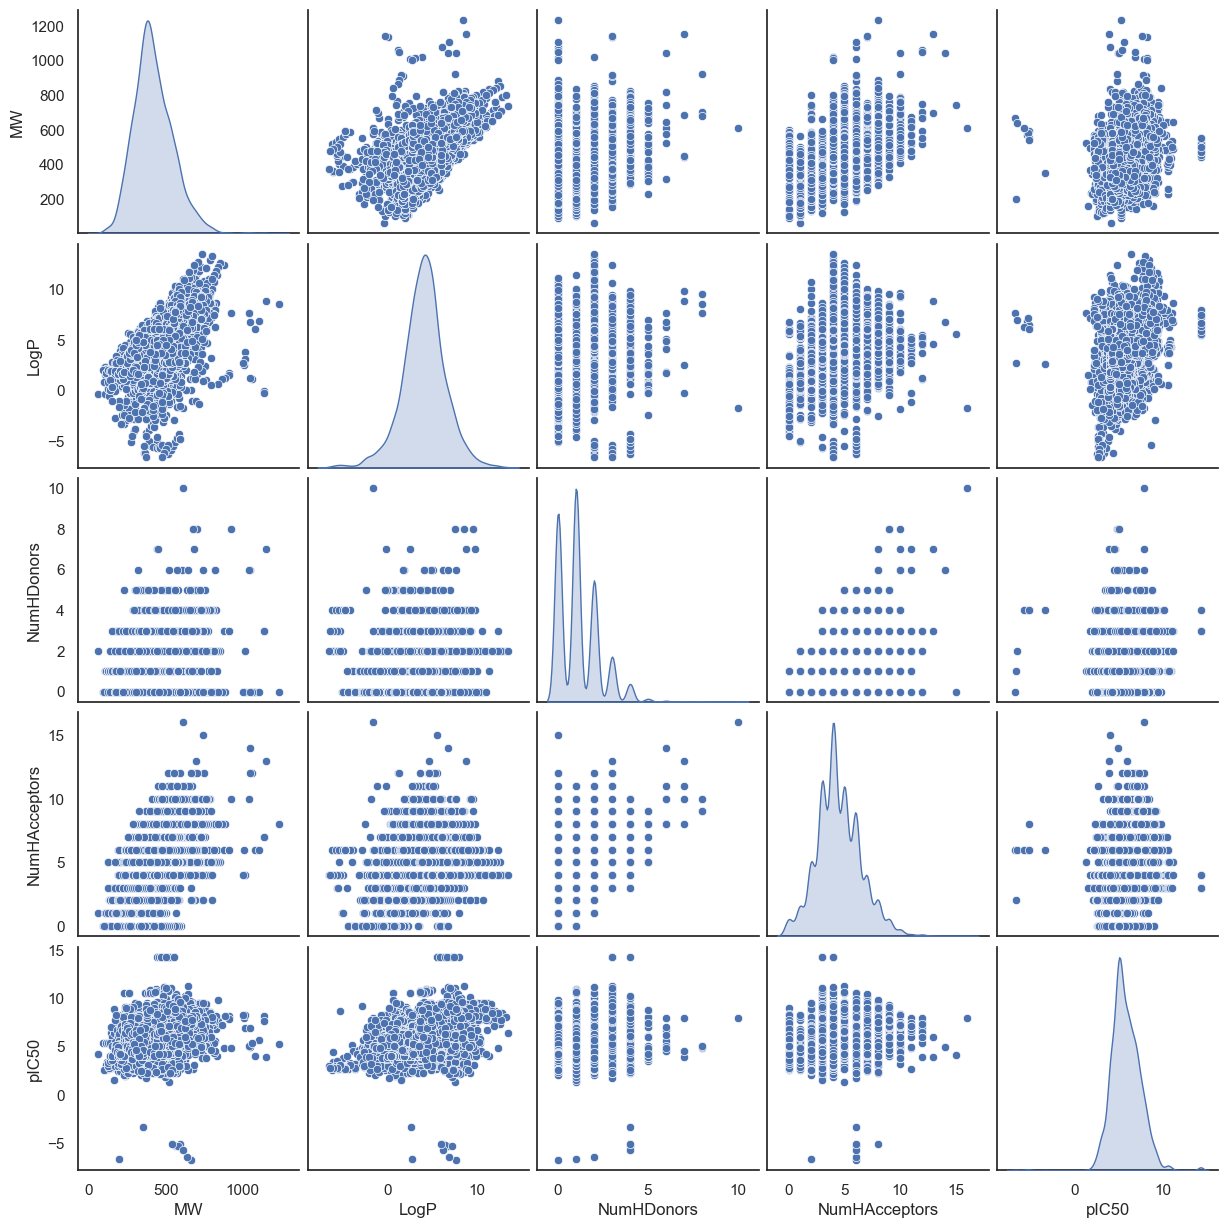

In [334]:
features = ['MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
sns.pairplot(df_combined[features+['pIC50']], diag_kind='kde')

## Network Model

In [226]:
from datetime import datetime as dt

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras import backend as K

from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Normalization,
    BatchNormalization
)

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


In [ ]:
LIPINSKY_DATA_PATH = 'data/acetylcholinesterase_02_bioactivity_data_preprocessed_with_lipinkski_desc.pkl'

df = pd.read_pickle(LIPINSKY_DATA_PATH)

In [193]:
from sklearn.model_selection import train_test_split

y = df.pIC50
X = df[['MW', 'LogP', 'NumHDonors', 'NumHAcceptors']]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=88
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    random_state=88
)

len(X_train), len(X_val), len(X_test)

(3726, 932, 1165)

In [194]:
# Métrica
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def calculate_r2(y_true, y_pred, _round=8):
    return round(1 - ((y_true.values - y_pred.reshape(-1)) ** 2).sum() / ((y_true - y_true.mean()) ** 2).sum(), _round)

In [195]:
# ModelCheckpoint
mcp = ModelCheckpoint(
    'models/best_model_{epoch}', 
    save_best_only=True, 
    save_format="h5",
)

In [196]:
# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,                  # number of epochs with no improvement (0 means the training 
                                  # is terminated as soon as the performance measure gets worse 
                                  # from one epoch to the next)
    restore_best_weights=True
)

In [206]:
# Tensorboard
tensorboard = TensorBoard(
    log_dir="logs/fit/model-lipinsky",
    histogram_freq=1,
    write_graph=False,
    write_images=False
)

In [360]:
def create_model(normalizer: None) -> Sequential:
    """ """
    
    # Model params 
    dropout_rate = 0
    add_bn = True
    hidden_layer_config = [
        {"units": 200, "activation": "relu", "dropout_rate": dropout_rate},
        {"units": 100, "activation": "relu", "dropout_rate": dropout_rate},
        {"units": 50, "activation": "relu", "dropout_rate": dropout_rate},
        {"units": 10, "activation": "relu", "dropout_rate": dropout_rate},
        ]

    output_layer_activation = None  # "linear"
        
    # Models
    model = Sequential()
    
    if normalizer is not None:
        model.add(normalizer)
    
    # Top fully-connected layer
    for layer in hidden_layer_config:
        dropout_rate = layer.get("dropout_rate", 0)
        if dropout_rate:
            model.add(Dropout(dropout_rate))
        model.add(Dense(layer["units"]))
        if layer.get("add_bn", add_bn):
            model.add(BatchNormalization())  # util para redes profundas
        model.add(Activation(layer["activation"]))

    # Output layer
    model.add(Dense(1, activation=output_layer_activation))

    return model


In [361]:
normalizer = Normalization(axis=-1)  # Normalization(input_shape=[1,], axis=None)

normalizer.adapt(
    np.array(X_train[features])  # horsepower = np.array(train_features['Horsepower'])
)


In [362]:
model = create_model(
    normalizer=normalizer
)

In [363]:
# model.summary()

In [364]:
model.compile(
    optimizer=Adam(
        learning_rate=0.001
    ),  # RMSprop, Adam, Nadam
    loss="mse",  # mean_absolute_error
    metrics=[R2]
)

In [365]:
model_name = "MLP"
tensorboard.log_dir = f"logs/fit/model-lipinsky-{model_name}-{dt.now().strftime('%Y%m%d_%H%M')}"

EPOCHS = 500

history = model.fit(
    X_train, 
    y_train, 
    epochs=EPOCHS, 
    batch_size=128, 
    validation_data=(X_val, y_val), 
    callbacks=[
        # mcp,
        early_stopping,
        tensorboard
    ],
    verbose=0,
)

In [366]:
y_pred = model.predict(X_test)  # 120 epochs

37/37 [==============================] - 1s 4ms/step


In [367]:
# Score
print(f"R2: {calculate_r2(y_test, y_pred, 3)}; ref value: 0.498")
# 

# 100 -> .246

R2: 0.241; ref value: 0.498


In [ ]:
# from helpers import plot_history
# plot_history(history)

## Evaluación

<function matplotlib.pyplot.show(close=None, block=None)>

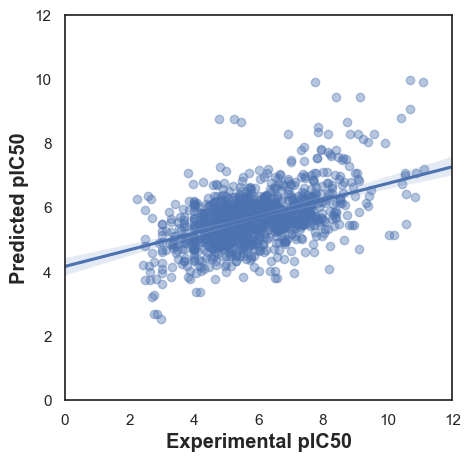

In [368]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

## Evaluación

Según las pruebas realizadas, no se logró llegar a valores similares de performance empleando únicamente los descriptores de Lipinsky y una red MPL. Como posibles próximos pasos se podría evaluar la utilización de fingerprints